# Flask App Metrics Analysis

This notebook analyzes the metrics data collected from the Flask application running in Kubernetes. We'll visualize how different metrics change over time:

- Number of instances (pod count)
- CPU Usage
- Requests per second
- Service time
- Workload (arrival rate of requests)

The visualization will help us understand how these metrics relate to each other and identify patterns in the system's behavior.

In [1]:
# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

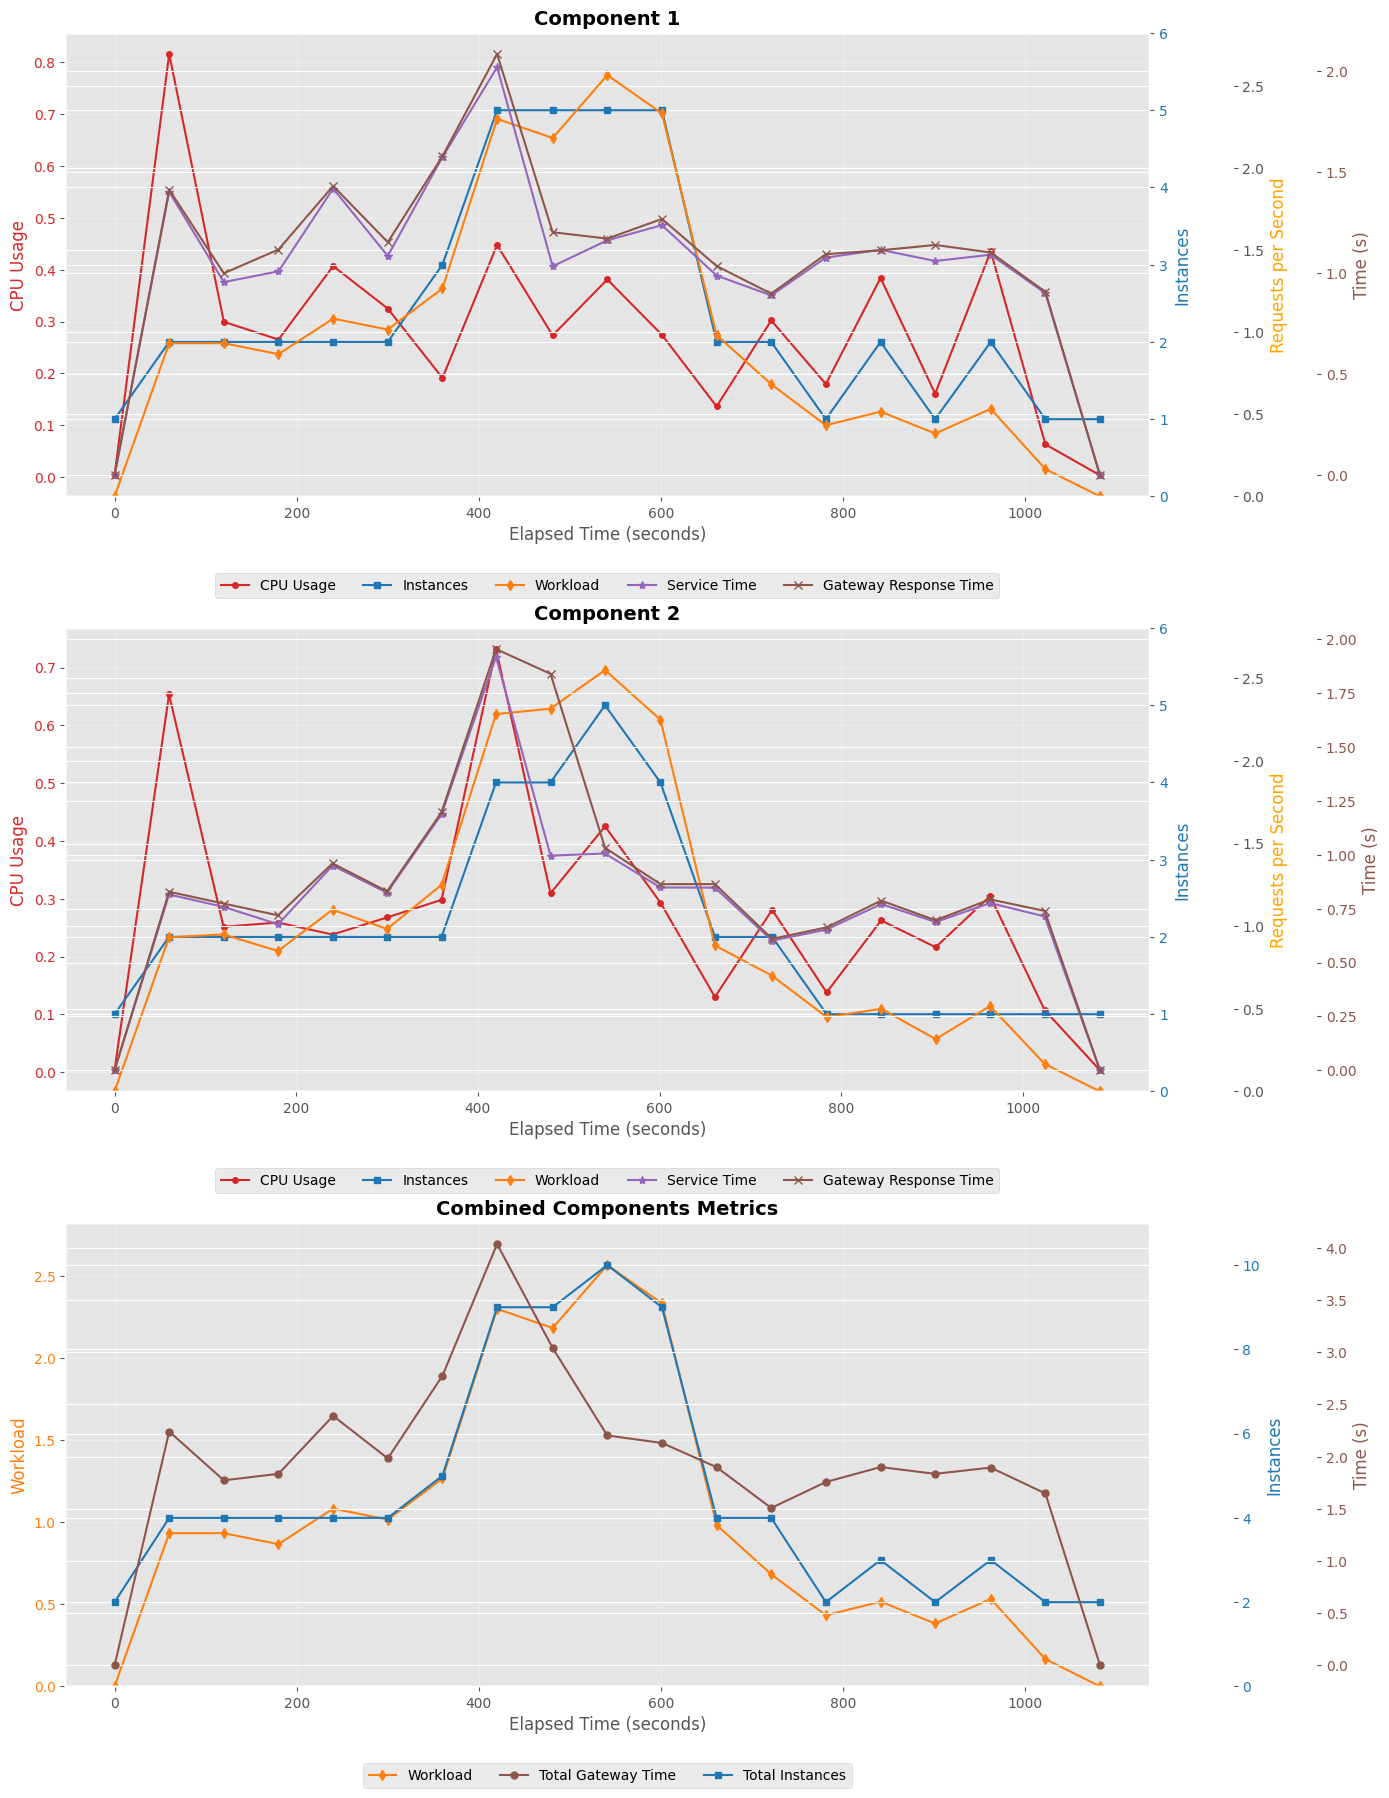

In [43]:
def plot_comparison_with_total_response_time(file_path1, file_path2):
    """
    Create a comparison plot with 3 subplots:
    1. Component 1 metrics
    2. Component 2 metrics  
    3. Combined metrics with total response time and total instances
    """
    
    # Load both files
    with open(file_path1, 'r') as file1:
        data1 = json.load(file1)
    with open(file_path2, 'r') as file2:
        data2 = json.load(file2)
    
    df1 = pd.DataFrame(data1['history'])
    df2 = pd.DataFrame(data2['history'])
    
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
    
    df1_plot = df1.copy().set_index('elapsed_seconds')
    df2_plot = df2.copy().set_index('elapsed_seconds')
    
    # Calculate total response time by simply adding the values at each index (no index alignment)
    gt1 = df1.get('gateway_mean_response_time', pd.Series(dtype=float)).values
    gt2 = df2.get('gateway_mean_response_time', pd.Series(dtype=float)).values
    min_len = min(len(gt1), len(gt2))
    total_response_time = gt1[:min_len] + gt2[:min_len]
    elapsed = df1['elapsed_seconds'].values[:min_len]
    
    # Calculate total instances at each time step
    instances1 = df1_plot['instances'].values[:min_len]
    instances2 = df2_plot['instances'].values[:min_len]
    total_instances = instances1 + instances2
    
    # Color definitions
    colors = {
        'cpu_usage': 'tab:red',
        'instances': 'tab:blue', 
        'completed_requests': 'tab:green',
        'mean_request_time': 'tab:purple',
        'workload': 'tab:orange',
        'gateway_mean_response_time': 'tab:brown',
        'total_response_time': 'tab:brown',
        'total_instances': 'tab:blue'
    }

    # Set plot style and size as in plot_metrics
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = (14, 8)

    # Create figure with 3 subplots (same width as plot_metrics)
    plt.figure(figsize=(14, 18))

    def plot_component_metrics(df_plot, subplot_pos, title):
        # subplot_pos should be 1-based for plt.subplot
        ax1 = plt.subplot(3, 1, subplot_pos)
        ax1.set_title(f'{title}', fontsize=14, fontweight='bold')
        
        # CPU Usage
        ax1.set_xlabel('Elapsed Time (seconds)')
        ax1.set_ylabel('CPU Usage', color=colors['cpu_usage'])
        ax1.plot(df_plot.index, df_plot['cpu_usage'], color=colors['cpu_usage'], marker='o', markersize=4, linestyle='-', label='CPU Usage')
        ax1.tick_params(axis='y', labelcolor=colors['cpu_usage'])
        
        # Instances
        ax2 = ax1.twinx()
        ax2.set_ylabel('Instances', color=colors['instances'])
        ax2.plot(df_plot.index, df_plot['instances'], color=colors['instances'], marker='s', linestyle='-', markersize=5, label='Instances')
        ax2.tick_params(axis='y', labelcolor=colors['instances'])
        ax2.set_ylim(0, max(df_plot['instances']) + 1)
        
        # Requests per second and workload
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))
        ax3.set_ylabel('Requests per Second', color='orange')
        # ax3.plot(df_plot.index, df_plot['requests_per_second'], color=colors['completed_requests'], marker='^', linestyle='-', markersize=5, label='Completed Req/s')
        
        if 'workload' in df_plot.columns:
            ax3.plot(df_plot.index, df_plot['workload'], color=colors['workload'], marker='d', linestyle='-', markersize=5, label='Workload')
            max_rate = max(df_plot['workload'].max() if not df_plot['workload'].empty else 0, df_plot['requests_per_second'].max() if not df_plot['requests_per_second'].empty else 0)
            ax3.set_ylim(0, max_rate * 1.1)
        else:
            ax3.set_ylim(0, df_plot['requests_per_second'].max() * 1.1)
        
        # Service time and gateway response time
        ax4 = ax1.twinx()
        ax4.spines['right'].set_position(('outward', 120))
        ax4.set_ylabel('Time (s)', color=colors['gateway_mean_response_time'])
        ax4.plot(df_plot.index, df_plot['mean_request_time'], color=colors['mean_request_time'], marker='*', linestyle='-', markersize=6, label='Service Time')
        ax4.tick_params(axis='y', labelcolor=colors['gateway_mean_response_time'])
        
        if 'gateway_mean_response_time' in df_plot.columns:
            ax4.plot(df_plot.index, df_plot['gateway_mean_response_time'], color=colors['gateway_mean_response_time'], marker='x', linestyle='-', markersize=6, label='Gateway Response Time')
        
        # Create legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines3, labels3 = ax3.get_legend_handles_labels()
        lines4, labels4 = ax4.get_legend_handles_labels()
        
        lines = lines1 + lines2 + lines3 + lines4
        labels = labels1 + labels2 + labels3 + labels4
        ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
        
        ax1.grid(True, alpha=0.3)
        return ax1

    # Plot Component 1 (subplot 1)
    plot_component_metrics(df1_plot, 1, 'Component 1')

    # Plot Component 2 (subplot 2)
    plot_component_metrics(df2_plot, 2, 'Component 2')

    # Plot Combined metrics with total response time and total instances (subplot 3)
    ax1 = plt.subplot(3, 1, 3)
    ax1.set_title('Combined Components Metrics', fontsize=14, fontweight='bold')

    ax1.set_xlabel('Elapsed Time (seconds)')
    ax1.set_ylabel('Workload', color=colors['workload'])
    if 'workload' in df1_plot.columns:
        ax1.plot(df1_plot.index[:min_len], df1_plot['workload'].values[:min_len], color=colors['workload'], marker='d', linestyle='-', markersize=5, label='Workload')
        ax1.set_ylim(0, df1_plot['workload'][:min_len].max() * 1.1)
    ax1.tick_params(axis='y', labelcolor=colors['workload'])

    # Plot total instances on a secondary y-axis
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Instances', color=colors['total_instances'])
    ax3.plot(df1_plot.index[:min_len], total_instances, color=colors['total_instances'], marker='s', linestyle='-', markersize=5, label='Total Instances')
    ax3.tick_params(axis='y', labelcolor=colors['total_instances'])
    ax3.set_ylim(0, max(total_instances) + 1)

    # Response times - individual components and total
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('outward', 120))
    ax2.set_ylabel('Time (s)', color=colors['gateway_mean_response_time'])

    # Individual component gateway response times
    # if 'gateway_mean_response_time' in df1_plot.columns:
    #     ax2.plot(df1_plot.index[:min_len], df1_plot['gateway_mean_response_time'].values[:min_len], color='tab:cyan', marker='v', linestyle='-', markersize=4, label='Component 1 Gateway Time')
    # if 'gateway_mean_response_time' in df2_plot.columns:
    #     ax2.plot(df2_plot.index[:min_len], df2_plot['gateway_mean_response_time'].values[:min_len], color='tab:olive', marker='^', linestyle='-', markersize=4, label='Component 2 Gateway Time')

    # Total response time
    ax2.plot(elapsed, total_response_time, color=colors['total_response_time'], marker='o', linestyle='-', markersize=5, label='Total Gateway Time')
    ax2.tick_params(axis='y', labelcolor=colors['gateway_mean_response_time'])

    # Create legend for combined plot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()

    lines = lines1 + lines2 + lines3
    labels = labels1 + labels2 + labels3
    ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)

    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Generate the comparison plot
plot_comparison_with_total_response_time(
    'flask-app-1_instance_history.json',
    'flask-app-2_instance_history.json'
)